In [341]:
# =========================
# STEP 0 — Imports + seeds
# =========================

import os  # file/folder operations
import random  # RNG
import numpy as np  # arrays and math

import mne  # EEG processing
import pywt  # wavelets for wICA

from sklearn.decomposition import FastICA  # ICA
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score  # metrics

import matplotlib.pyplot as plt  # plotting
import seaborn as sns  # plotting

import tensorflow as tf  # deep learning

# Set seeds (same values you used)
random.seed(42)  # set python seed
np.random.seed(42)  # set numpy seed
tf.random.set_seed(42)  # set TF seed

print("✅ [STEP 0] Imports loaded + seeds set.")  # progress log


✅ [STEP 0] Imports loaded + seeds set.


In [342]:
# ==========================================
# STEP 1 — Helper: load EEG (.set) + labels
# ==========================================

def load_eeg_data_with_target(  # define loader function
    folder_path: str,  # folder containing .set files
    session_name: str,  # session identifier
    max_samples: int = 118000,  # max samples
    discard_samples: int = 10000  # discard first samples
):
    eeg_files = [f for f in os.listdir(folder_path) if f.endswith(".set")]  # list .set files
    data_list = []  # store EEG arrays
    targets = []  # store labels
    sfreq_list = []  # store sampling frequencies

    print(f"📥 [STEP 1] Found {len(eeg_files)} .set file(s) in: {folder_path}")  # log

    for eeg_file in eeg_files:  # loop through files
        file_path = os.path.join(folder_path, eeg_file)  # build full path
        print(f"   ▶ Loading: {eeg_file}")  # log file being loaded

        raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=False)  # read .set
        data = raw.get_data().astype(np.float32)  # extract (C,T)
        sfreq = float(raw.info["sfreq"])  # get sampling rate

        if data.shape[1] > max_samples:  # if too long
            data = data[:, :max_samples]  # trim

        if data.shape[1] > discard_samples:  # if enough samples to discard
            data = data[:, discard_samples:]  # discard beginning
        else:  # too short to discard
            print(f"⚠️ Not enough samples to discard in {eeg_file}, skipping.")  # warn
            continue  # skip file

        data_list.append(data)  # append trial
        sfreq_list.append(sfreq)  # append fs

        if session_name == "ses-1":  # session 1
            targets.append(0)  # label 0
        elif session_name == "ses-2":  # session 2
            targets.append(1)  # label 1
        else:  # unknown session
            print(f"⚠️ Unknown session name: {session_name}")  # warn

    print(f"✅ [STEP 1] Loaded {len(data_list)} valid trial(s).")  # log
    return data_list, np.array(targets, dtype=np.int32), np.array(sfreq_list, dtype=np.float32)  # return


In [343]:
# ==================================================
# STEP 2 — Preprocessing classes (UNCHANGED)
# ==================================================

from typing import Optional, Union, Sequence, Dict, Tuple, List  # type hints

def _names_from_index_mapping(n_channels: int, index_to_name: Optional[Dict[int, str]]) -> List[str]:
    if index_to_name is None:
        return [f"EEG{i+1}" for i in range(n_channels)]
    keys = list(index_to_name.keys())
    is_zero_based = (0 in keys) and (1 not in keys)
    names = []
    for i in range(n_channels):
        key = i if is_zero_based else (i + 1)
        names.append(index_to_name.get(key, f"EEG{i+1}"))
    return names

def _make_raw(eeg: np.ndarray, sfreq: float, ch_names: List[str], use_standard_1020: bool = True) -> Tuple[mne.io.Raw, bool]:
    ch_types = ['eog' if str(n).upper().startswith("EOG") else 'eeg' for n in ch_names]
    info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)
    raw = mne.io.RawArray(eeg.astype(np.float32, copy=False), info, verbose=False)

    montage_applied = False
    if use_standard_1020:
        try:
            mont = mne.channels.make_standard_montage("standard_1020")
            raw.set_montage(mont, match_case=False, on_missing="ignore")
            montage_applied = True
        except Exception:
            montage_applied = False

    return raw, montage_applied

class WaveletICA:
    def __init__(self, wavelet="db4", level=3, n_components=10, random_state=42):
        self.wavelet = wavelet
        self.level = level
        self.n_components = n_components
        self.random_state = random_state
        self.ica_ = None
        self._n_ch = None

    def fit(self, X: np.ndarray):
        C = X.shape[0]
        self._n_ch = C

        coeffs = pywt.wavedec(X, wavelet=self.wavelet, level=self.level, axis=1)
        A = coeffs[0]

        k = int(min(self.n_components, C))
        self.ica_ = FastICA(n_components=k, random_state=self.random_state)

        S = self.ica_.fit_transform(A.T)
        A_denoised = self.ica_.inverse_transform(S).T

        coeffs[0] = A_denoised
        _ = pywt.waverec(coeffs, wavelet=self.wavelet, axis=1)

        return self

    def transform(self, X: np.ndarray) -> np.ndarray:
        assert self.ica_ is not None, "WaveletICA not fitted yet."

        coeffs = pywt.wavedec(X, wavelet=self.wavelet, level=self.level, axis=1)
        A = coeffs[0]

        S = self.ica_.transform(A.T)
        A_denoised = self.ica_.inverse_transform(S).T

        coeffs[0] = A_denoised
        Y = pywt.waverec(coeffs, wavelet=self.wavelet, axis=1)

        if Y.shape[1] < X.shape[1]:
            Y = np.pad(Y, ((0, 0), (0, X.shape[1] - Y.shape[1])), mode="constant")
        elif Y.shape[1] > X.shape[1]:
            Y = Y[:, :X.shape[1]]

        return Y.astype(np.float32, copy=False)

class EEGPreprocessor:
    def __init__(
        self,
        *,
        index_to_name: Optional[Dict[int, str]] = None,
        use_standard_1020: bool = True,
        resample_to: Optional[float] = None,
        notch_freqs: Union[None, float, Sequence[float]] = 50.0,
        highpass: Optional[float] = 0.05,
        bad_point_z: float = 6.0,
        bad_channel_z: float = 5.0,
        interpolate_bad_channels: bool = False,
        car: bool = True,
        use_wica: bool = True,
        wica_components: int = 10,
        wica_wavelet: str = "db4",
        wica_level: int = 3,
        wica_random_state: int = 42
    ):
        self.index_to_name = index_to_name
        self.use_standard_1020 = use_standard_1020
        self.resample_to = resample_to
        self.notch_freqs = notch_freqs
        self.highpass = highpass
        self.bad_point_z = bad_point_z
        self.bad_channel_z = bad_channel_z
        self.interpolate_bad_channels = interpolate_bad_channels
        self.car = car
        self.use_wica = use_wica

        self._sfreq_out = None
        self._train_mu = None
        self._train_sd = None

        self._wica = WaveletICA(
            wavelet=wica_wavelet,
            level=wica_level,
            n_components=wica_components,
            random_state=wica_random_state
        )

    @property
    def sfreq_out(self) -> float:
        assert self._sfreq_out is not None, "Preprocessor not run yet."
        return float(self._sfreq_out)

    def _filter_and_reference(self, raw: mne.io.Raw):
        if self.resample_to is not None and float(self.resample_to) != float(raw.info["sfreq"]):
            raw.resample(self.resample_to, npad="auto")

        self._sfreq_out = float(raw.info["sfreq"])

        if self.notch_freqs is not None:
            raw.notch_filter(freqs=self.notch_freqs, verbose=False)

        if self.highpass is not None:
            raw.filter(l_freq=self.highpass, h_freq=None, verbose=False)

        if self.car:
            raw.set_eeg_reference("average", projection=True)
            raw.apply_proj()

    def _repair_transients_with_train_stats(self, raw: mne.io.Raw):
        X = raw.get_data()
        mu = self._train_mu
        sd = self._train_sd
        assert mu is not None and sd is not None, "Training stats not set."

        hi = mu + self.bad_point_z * sd
        lo = mu - self.bad_point_z * sd
        mask = (X > hi) | (X < lo)

        if np.any(mask):
            X_fixed = X.copy()
            t = np.arange(X.shape[1], dtype=float)
            for ch in range(X.shape[0]):
                m = mask[ch]
                if m.any():
                    good = ~m
                    if good.sum() >= 2:
                        X_fixed[ch, m] = np.interp(t[m], t[good], X_fixed[ch, good])
            raw._data = X_fixed

    def fit(self, X_train: np.ndarray, sfreq: float):
        C = X_train.shape[0]
        ch_names = _names_from_index_mapping(C, self.index_to_name)

        raw_train, _ = _make_raw(X_train, sfreq, ch_names, self.use_standard_1020)
        self._filter_and_reference(raw_train)

        Xt = raw_train.get_data()
        self._train_mu = Xt.mean(axis=1, keepdims=True)
        self._train_sd = Xt.std(axis=1, keepdims=True) + 1e-12

        self._repair_transients_with_train_stats(raw_train)
        Xt = raw_train.get_data()

        if self.use_wica:
            self._wica.fit(Xt)

        return self

    def transform(self, X: np.ndarray, sfreq: float) -> Tuple[np.ndarray, float]:
        C = X.shape[0]
        ch_names = _names_from_index_mapping(C, self.index_to_name)

        raw, _ = _make_raw(X, sfreq, ch_names, self.use_standard_1020)
        self._filter_and_reference(raw)
        self._repair_transients_with_train_stats(raw)

        Xf = raw.get_data()
        if self.use_wica:
            Xf = self._wica.transform(Xf)

        return Xf.astype(np.float32, copy=False), self.sfreq_out

print("✅ [STEP 2] Preprocessing classes loaded.")  # progress log


✅ [STEP 2] Preprocessing classes loaded.


In [344]:
# ==========================
# STEP 3 — Load trained model
# ==========================

print("📥 [STEP 3] Loading model from working directory...")  # log

model_path = "EEGNet-SD-Final.keras"  # model file name

if not os.path.isfile(model_path):  # check existence
    raise RuntimeError(f"❌ [STEP 3] Model not found: {model_path}")  # error

model = tf.keras.models.load_model(model_path)  # load saved model

print("✅ [STEP 3] Model loaded successfully.")  # log
print(model.summary())  # print model summary


📥 [STEP 3] Loading model from working directory...
✅ [STEP 3] Model loaded successfully.


Model: "EEGNet_simple"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 61, 100, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 61, 100, 16)    │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 61, 100, 16)    │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d                │ (None, 1, 100, 32)     │         1,952 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1, 100, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 1, 100, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 1, 25, 32)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 25, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d                │ (None, 1, 25, 16)      │         1,024 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1, 25, 16)      │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 1, 25, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 1, 3, 16)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1, 3, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,117 (86.40 KB)

 Trainable params: 7,329 (28.63 KB)

 Non-trainable params: 128 (512.00 B)

 Optimizer params: 14,660 (57.27 KB)

None


In [345]:
# ===================================
# STEP 4 — Load TEST subject/session
# ===================================

print("🧪 [STEP 4] Loading TEST: sub-02 / ses-2 ...")  # log

# IMPORTANT: set this base_path to your dataset folder on disk
# Example matches your training code's base_path pattern after download:
base_path = "./azureml_eeg_data/UI/2025-12-11_033542_UTC/New Dataset"  # dataset root

test_sub = "sub-37"  # subject
test_ses = "ses-2"  # session

test_path = os.path.join(base_path, test_sub, test_ses)  # full folder

print(f"📁 [STEP 4] test_path = {test_path}")  # log

if not os.path.isdir(test_path):  # validate path
    raise RuntimeError(f"❌ [STEP 4] Folder not found: {test_path}")  # error

test_raw_list, test_targets, test_sfreqs = load_eeg_data_with_target(test_path, test_ses)  # load trials

if len(test_raw_list) == 0:  # ensure data exists
    raise RuntimeError("❌ [STEP 4] No valid trials loaded for test subject.")  # error

fs = float(test_sfreqs[0])  # use first fs

print(f"✅ [STEP 4] Loaded {len(test_raw_list)} trial(s).")  # log
print(f"✅ [STEP 4] Labels: {np.unique(test_targets, return_counts=True)}")  # log
print(f"✅ [STEP 4] fs = {fs}")  # log


🧪 [STEP 4] Loading TEST: sub-02 / ses-2 ...
📁 [STEP 4] test_path = ./azureml_eeg_data/UI/2025-12-11_033542_UTC/New Dataset/sub-37/ses-2
📥 [STEP 1] Found 1 .set file(s) in: ./azureml_eeg_data/UI/2025-12-11_033542_UTC/New Dataset/sub-37/ses-2
   ▶ Loading: sub-37_ses-2_task-eyesclosed_eeg.set
✅ [STEP 1] Loaded 1 valid trial(s).
✅ [STEP 4] Loaded 1 trial(s).
✅ [STEP 4] Labels: (array([1], dtype=int32), array([1]))
✅ [STEP 4] fs = 500.0


In [346]:
# =========================================
# STEP 5 — Fit preprocessor (test calibration)
# =========================================

print("🧼 [STEP 5] Creating EEGPreprocessor (same params)...")  # log

pre = EEGPreprocessor(
    index_to_name=None,  # same
    use_standard_1020=True,  # same
    resample_to=None,  # same
    notch_freqs=[50.0, 100.0, 150.0],  # same
    highpass=0.05,  # same
    bad_point_z=6.0,  # same
    bad_channel_z=5.0,  # same
    interpolate_bad_channels=False,  # same
    car=True,  # same
    use_wica=True,  # same
    wica_components=10,  # same
    wica_wavelet="db4",  # same
    wica_level=3,  # same
    wica_random_state=42,  # same
)

print("📐 [STEP 5] Building calibration data from first up-to-10 trials...")  # log

max_calib_trials = min(10, len(test_raw_list))  # same rule
calib_trials = test_raw_list[:max_calib_trials]  # slice

X_calib = np.concatenate(calib_trials, axis=1).astype(np.float32, copy=False)  # concat time

print(f"✅ [STEP 5] Calibration shape: {X_calib.shape}")  # log

pre.fit(X_calib, fs)  # fit preprocessor

print(f"✅ [STEP 5] Preprocessor fitted. fs_out={pre.sfreq_out}")  # log


🧼 [STEP 5] Creating EEGPreprocessor (same params)...
📐 [STEP 5] Building calibration data from first up-to-10 trials...
✅ [STEP 5] Calibration shape: (61, 108000)
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
✅ [STEP 5] Preprocessor fitted. fs_out=500.0


In [347]:
# ==========================
# STEP 6 — Preprocess trials
# ==========================

print("🧼 [STEP 6] Preprocessing all test trials...")  # log

test_clean = []  # store cleaned trials

for i, trial in enumerate(test_raw_list):  # loop trials
    X_clean, _ = pre.transform(trial, fs)  # preprocess trial
    test_clean.append(X_clean.astype(np.float32, copy=False))  # store
    print(f"✅ [STEP 6] Preprocessed trial {i+1}/{len(test_raw_list)}")  # log

test_clean = np.array(test_clean, dtype=np.float32)  # list -> array

print(f"✅ [STEP 6] test_clean shape: {test_clean.shape}")  # log


🧼 [STEP 6] Preprocessing all test trials...
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
✅ [STEP 6] Preprocessed trial 1/1
✅ [STEP 6] test_clean shape: (1, 61, 108000)


In [348]:
# =================================
# STEP 7 — Segment into 100 samples
# =================================

print("🧩 [STEP 7] Segmenting trials into 100-sample windows...")  # log

def augment_data(data: np.ndarray, target: int, segment_size: int = 100):  # same logic
    augmented_data = []  # segments
    augmented_targets = []  # labels

    if data.ndim == 3:  # extra dim check
        data = data[0]  # squeeze

    n_segments = data.shape[1] // segment_size  # full windows only

    for i in range(n_segments):  # loop windows
        seg = data[:, i * segment_size:(i + 1) * segment_size]  # slice segment
        augmented_data.append(seg.astype(np.float32, copy=False))  # store segment
        augmented_targets.append(int(target))  # store label

    return augmented_data, augmented_targets  # return

test_segments = []  # store all segments
test_seg_targets = []  # store all segment labels

for trial, y in zip(test_clean, test_targets):  # loop trials
    segs, ys = augment_data(trial, int(y), segment_size=100)  # split
    test_segments.extend(segs)  # add segments
    test_seg_targets.extend(ys)  # add labels

test_segments = np.array(test_segments, dtype=np.float32)  # to array
test_seg_targets = np.array(test_seg_targets, dtype=np.int32)  # to array

print(f"✅ [STEP 7] test_segments shape: {test_segments.shape}")  # log
print(f"✅ [STEP 7] segment label counts: {np.unique(test_seg_targets, return_counts=True)}")  # log


🧩 [STEP 7] Segmenting trials into 100-sample windows...
✅ [STEP 7] test_segments shape: (1080, 61, 100)
✅ [STEP 7] segment label counts: (array([1], dtype=int32), array([1080]))


In [349]:
# ================================================
# STEP 8 — Reshape + normalize (TEST mean/std)
# ================================================

print("📦 [STEP 8] Reshaping segments for CNN input...")  # log

X_test_raw = test_segments[..., np.newaxis].astype(np.float32, copy=False)  # (N,C,T,1)
y_test = test_seg_targets.astype(np.int32, copy=False)  # labels

print(f"✅ [STEP 8] X_test_raw shape: {X_test_raw.shape}")  # log
print(f"✅ [STEP 8] y_test shape: {y_test.shape}")  # log

print("📏 [STEP 8] Computing TEST normalization stats using SAME axes (0,2,3)...")  # log

epsilon = 1e-6  # same epsilon
test_mean = np.mean(X_test_raw, axis=(0, 2, 3), keepdims=True).astype(np.float32)  # mean per electrode
test_std = np.std(X_test_raw, axis=(0, 2, 3), keepdims=True).astype(np.float32)  # std per electrode
test_std = np.maximum(test_std, epsilon).astype(np.float32)  # clamp std

X_test_norm = ((X_test_raw - test_mean) / test_std).astype(np.float32)  # normalize

print("✅ [STEP 8] Normalization complete (test_mean/test_std).")  # log
print(f"   test_mean shape: {test_mean.shape}")  # log
print(f"   test_std shape : {test_std.shape}")  # log


📦 [STEP 8] Reshaping segments for CNN input...
✅ [STEP 8] X_test_raw shape: (1080, 61, 100, 1)
✅ [STEP 8] y_test shape: (1080,)
📏 [STEP 8] Computing TEST normalization stats using SAME axes (0,2,3)...
✅ [STEP 8] Normalization complete (test_mean/test_std).
   test_mean shape: (1, 61, 1, 1)
   test_std shape : (1, 61, 1, 1)


🧪 [STEP 9] Running predictions on normalized TEST data...
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
✅ [STEP 9] Predictions complete.
   Prob min/max: 0.0001 / 0.9999
   Pred counts : (array([0, 1]), array([646, 434]))
📊 [STEP 9] Confusion matrix...
[[  0   0]
 [646 434]]


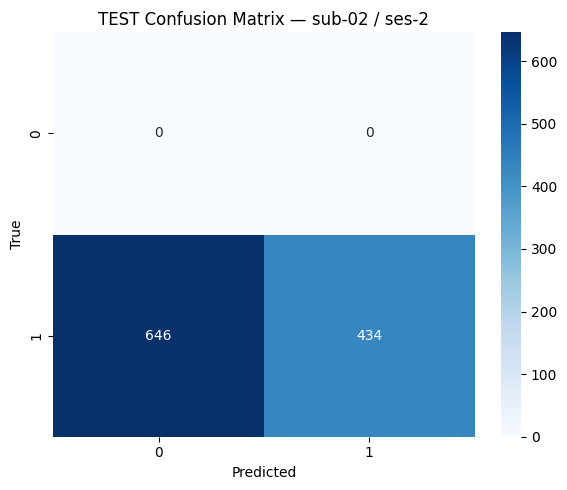

/anaconda/envs/azureml_py38_PT_TF/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/anaconda/envs/azureml_py38_PT_TF/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/anaconda/envs/azureml_py38_PT_TF/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.sh

In [350]:
# =====================================
# STEP 9 — Predict + metrics + plots
# =====================================

print("🧪 [STEP 9] Running predictions on normalized TEST data...")  # log

y_prob = model.predict(X_test_norm, batch_size=200, verbose=1).reshape(-1)  # probabilities
y_pred = (y_prob > 0.5).astype(int)  # binary predictions

print("✅ [STEP 9] Predictions complete.")  # log
print(f"   Prob min/max: {float(np.min(y_prob)):.4f} / {float(np.max(y_prob)):.4f}")  # log
print(f"   Pred counts : {np.unique(y_pred, return_counts=True)}")  # log

print("📊 [STEP 9] Confusion matrix...")  # log
cm = confusion_matrix(y_test.astype(int), y_pred.astype(int))  # compute CM
print(cm)  # print CM

plt.figure(figsize=(6, 5))  # figure
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=True)  # heatmap
plt.title("TEST Confusion Matrix — sub-02 / ses-2")  # title
plt.xlabel("Predicted")  # label
plt.ylabel("True")  # label
plt.tight_layout()  # layout
plt.savefig("test_sub-02_ses-2_confusion_matrix.png", dpi=300, bbox_inches="tight")  # save
plt.show()  # show
print("✅ [STEP 9] Saved: test_sub-02_ses-2_confusion_matrix.png")  # log

print("🧾 [STEP 9] Classification report...")  # log
print(classification_report(y_test.astype(int), y_pred.astype(int), target_names=["Class 0", "Class 1"]))  # report

print("📈 [STEP 9] AUC (only if both classes present)...")  # log
try:
    auc_val = float(roc_auc_score(y_test.astype(int), y_prob))  # compute auc
    print(f"✅ [STEP 9] AUC: {auc_val:.4f}")  # log
except Exception as e:
    print(f"⚠️ [STEP 9] AUC not computed. Reason: {e}")  # log

print("✅ [FINAL] Done testing sub-02 / ses-2.")  # final log
